In [1]:
import pickle
import matplotlib.pyplot as plt
import os
import h5py
import torch
import torch.nn.functional as F
from tqdm import tqdm
synthetic_params = "/home/kevin/bll-piglets-helicoid/dataset/synthetic_no_scattering/params.pkl"
synthetic_spectra = "/home/kevin/bll-piglets-helicoid/dataset/synthetic_no_scattering/spectra.pkl"

In [2]:
os.chdir("..")

In [3]:
from data_processing.generate_dataset import *
from optimisation import *
import data_processing.preprocessing as preprocessing
from wavelength_selection import *

PATH:  /home/kevin/bll-piglets-helicoid


# I. Preservation Methods

# II. Orthogonality Methods

# III. Projection Methods

## 1. Wavelength Selection

## 2. Chromophore Selection

In [4]:
def find_chromophores(chromophores, chromophore_names, projection_metric, chromophore_metric, spectr):
    projection_result = []
    for k in tqdm(range(1, len(chromophores) + 1)):
        results = []
        results_names = []
        for combo_indices in combinations(range(len(chromophores)), k):
            combo = [chromophores[i] for i in combo_indices] 
            results.append(np.transpose(np.vstack(combo)))
            #results_names.append('+'.join([chromophore_names[i] for i in combo_indices]))
            results_names.append(([chromophore_names[i] for i in combo_indices]))

        for i, M in enumerate(results):
            #wavelengths_downsampled = wavelengths[::5]
            #M_downsampled = M[::5,:]
            #comp_spectr_downsampled = comp_spectr[::7,::5]
            #plt.figure()
            #print(results_names[i])
            #M_red, remaining_indices = reduce_wavelengths(M, spectr.T[:, :], num_of_final_wavelengths, projection_metric)
            #plt.plot(wavelengths, M)
            #plt.vlines(wavelengths[remaining_indices], np.min(M), np.max(M), color="black", linestyle="dashed", alpha=0.5)
            #print(wavelengths_downsampled[remaining_indices])
            projection_error = projection_metric(M,spectr.T)
            #print(projection_error)
            #projection_result.append((k, results_names[i], M, projection_error, 1 / (np.prod(np.linalg.svd(M, compute_uv=False))/k)))    
            projection_result.append((k, results_names[i], M, projection_error, chromophore_metric(M, spectr.T)))
            plt.show()

    return projection_result

def find_chromophores_and_wavelengths(num_of_final_wavelengths, wavelengths, chromophores, chromophore_names, 
                                      projection_metric, chromophore_metric, comp_spectr):
    projection_result = []
    for k in tqdm(range(1, len(chromophores) + 1)):
        results = []
        results_names = []
        for combo_indices in combinations(range(len(chromophores)), k):
            combo = [chromophores[i] for i in combo_indices] 
            results.append(np.transpose(np.vstack(combo)))
            #results_names.append('+'.join([chromophore_names[i] for i in combo_indices]))
            results_names.append(([chromophore_names[i] for i in combo_indices]))

        for i, M in enumerate(results):
            wavelengths_downsampled = wavelengths
            M_downsampled = M
            k = M.shape[1]
            comp_spectr_downsampled = comp_spectr
            M_red, remaining_indices = reduce_wavelengths(M_downsampled, comp_spectr_downsampled.T[:, :], num_of_final_wavelengths, projection_metric)
            projection_error = projection_metric(M_downsampled[remaining_indices,:],comp_spectr_downsampled.T[remaining_indices, :])
            projection_result.append((k, results_names[i], projection_error, wavelengths_downsampled[remaining_indices], wavelengths_downsampled))

    return projection_result

def projection_metric(M, X):
    #print((pinv(M) @ X).shape)
    #print(M.shape)
    #print(X.shape)
    return np.mean(((M @ (pinv(M) @ X)) - X)**2)

def chromophore_metric(M, X):
    k = M.shape[1]
    #M_normalized = (M - M.min(axis=0)) / (M.max(axis=0) - M.min(axis=0))
    #M_normalized = M
    #return 1 / (np.prod(np.linalg.svd(M_normalized, compute_uv=False))/k)
    #return 1 / (np.prod(np.linalg.svd(M_normalized, compute_uv=False)))
    return k
         
def normalize(data):
    return data / np.min(data)

def reduce_wavelengths(M, X, desired_num_wavelengths, compute_metric):
    if desired_num_wavelengths >= M.shape[0]:
        #print("Desired number of wavelengths is >= current number of wavelengths.")
        return M, np.arange(M.shape[0])

    remaining_indices = np.arange(M.shape[0])
    
    #with tqdm(total = M.shape[0] - desired_num_wavelengths) as pbar:
    while M.shape[0] > desired_num_wavelengths:
        metrics = []
        #projection_error = np.abs(((M @ (pinv(M) @ X)) - X))
        for i in (range(M.shape[0])):
            M_reduced = np.delete(M, i, axis=0)
            X_reduced = np.delete(X, i, axis=0)
            metric = compute_metric(M_reduced, X_reduced)
            metrics.append(metric)

        #print(metrics)
        index_to_remove = np.argmin(metrics)
        M = np.delete(M, index_to_remove, axis=0)
        X = np.delete(X, index_to_remove, axis=0)
        remaining_indices = np.delete(remaining_indices, index_to_remove)
        #pbar.update(1)
            #print(M.shape)

    return M, remaining_indices

def run_chromophore_selection(spectra, save_name=""):
    #projection_result = find_chromophores([y_hbo2_f, y_hb_f, y_coxa - y_creda, y_water, y_fat, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red], 
    #                                      ["$HbO_2$", "$HHb$", "$diffCCO$", "Water", "Fat", "oxCC", "redCC", "oxCB", "redCB"], projection_metric, chromophore_metric, spectra[:,:,0])
    projection_result = find_chromophores([y_hbo2_f, y_hb_f, y_coxa - y_creda, y_water, y_fat, y_cytoc_oxy - y_cytoc_red, y_cytob_oxy - y_cytob_red], 
                                          ["$HbO_2$", "$HHb$", "$diffCCO$", "Water", "Fat", "diffCC", "diffCB"], projection_metric, chromophore_metric, spectra[:,:,0])
    projection_result_sorted = (sorted(projection_result, key=lambda x: (x[3], x[4])))
    
    projection_result_sorted = (sorted(projection_result, key=lambda x: (x[4])))
    errors_projection = []
    
    fitting_error = []
    svdprod_inv = []
    name = []
    for result in projection_result_sorted:
        #errors_projection.append(result[2])
        errors_projection.append((result[0], result[3], result[1]))
        fitting_error.append(result[3])
        svdprod_inv.append(result[4])
        name.append(result[1])
    
    fitting_error = normalize(np.array(fitting_error))
    svdprod_inv = normalize(np.array(svdprod_inv))
    
    eucl_distance_index = np.argsort(np.sqrt(np.array(fitting_error)**2 + np.array(svdprod_inv)**2))
    
    fig,axs = plt.subplots(1,1, figsize=(6,4))
    axs = [axs]
    axs[0].scatter(fitting_error, svdprod_inv)
    
    for index in eucl_distance_index:
        #print(name[index])
        if set(chosen_chromophore_names) == set(name[eucl_distance_index[index]]):
               axs[0].scatter(fitting_error[eucl_distance_index[index]], svdprod_inv[eucl_distance_index[index]], label="{$HbO_2$, $HHb$, $diffCCO$, ...}",color="orange")
        elif set(chosen_chromophore_names).issubset(set(name[eucl_distance_index[index]])):
               axs[0].scatter(fitting_error[eucl_distance_index[index]], svdprod_inv[eucl_distance_index[index]], color="orange") 
        #if set(chosen_chromophore_names).issubset(name[eucl_distance_index[index]]):
        #    axs[0].scatter(fitting_error[eucl_distance_index[index]], svdprod_inv[eucl_distance_index[index]], label=name[eucl_distance_index[index]], color="orange")
    
    
    axs[0].set_xlabel("Normalized Projection Error")
    #axs[0].set_ylabel("1 / (Product SVD Values)")
    axs[0].set_ylabel("k")
    axs[0].set_xscale("log")
    #axs[0].set_yscale("log")
    #axs[0].set_title("Chromophore Set Selection for " +  str(len(projection_result_sorted[eucl_distance_index[0]][-3])) + " wavelengths")
    #axs[0].set_title("Chromophore Selection for " + str(np.round(x[0][0],1)) + "nm - " + str(np.round(x[-1][0],1)) + "nm with " + str(chosen_chromophore_names))
    
    #axs[0].set_title("Chromophore Selection with " + str(chosen_chromophore_names))
    axs[0].set_title("Chromophore Combination Comparison")
    axs[0].legend()
    fig.tight_layout()
    fig.savefig("chromophore_selection_" + save_name)
    
    name = []
    fitting_error_arr = []
    for result in projection_result_sorted:
        #errors_projection.append(result[2])
        fitting_error_arr.append(result[3])
    
    min_fitting_error = np.min(np.array(fitting_error_arr))
    print(min_fitting_error)
    
    projection_result_sorted = (sorted(projection_result, key=lambda x: (x[3])))
    projection_result_sorted
    import pandas as pd
    df = pd.DataFrame(projection_result, columns=['length', 'chromophores', 'x', 'mean_error', 'length_dup'])
    top_3_results = df.groupby('length').apply(lambda group: group.nsmallest(1, 'mean_error')).reset_index(drop=True)
    
    x_axis = []
    x_axis_label = []
    y_axis = []
    for i in range(len(top_3_results)):
        print([tuple(row) for row in top_3_results.to_numpy()][i][1], [tuple(row) for row in top_3_results.to_numpy()][i][3])
        x_axis.append(i)
        if i < 7:
            x_axis_label.append("\n"*i+str([tuple(row) for row in top_3_results.to_numpy()][i][1]))
        else:
            x_axis_label.append("")
        y_axis.append([tuple(row) for row in top_3_results.to_numpy()][i][3] / min_fitting_error)
    
    plt.figure(figsize=(6,4))
    plt.plot(x_axis,y_axis)
    plt.scatter(x_axis,y_axis)
    plt.xticks(x_axis, x_axis_label, fontsize=8)
    plt.hlines(1,0,6, linestyles='--',alpha=0.7, color="orange")
    plt.yscale("log")
    
    plt.ylabel("Normalized Projection Error",fontsize=9)
    plt.title("Best Chromophore Candidate for increasing $k$", fontsize=10)
    #for i in range(len(projection_result_sorted)):
    #    print(projection_result_sorted[i][1], projection_result_sorted[i][3])
    plt.tight_layout()
    plt.savefig("chromophore_candidate_increasing_k_" + save_name)


def run_chromophore_wavelength_selection(spectra, num_of_final_wavelengths, coarseness=1, data_coarseness=1, save_name=""):
    #projection_result = find_chromophores([y_hbo2_f, y_hb_f, y_coxa - y_creda, y_water, y_fat, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red], 
    #                                      ["$HbO_2$", "$HHb$", "$diffCCO$", "Water", "Fat", "oxCC", "redCC", "oxCB", "redCB"], projection_metric, chromophore_metric, spectra[:,:,0])
    projection_result = find_chromophores_and_wavelengths(num_of_final_wavelengths, wavelengths[::coarseness], [y_hbo2_f[::coarseness], y_hb_f[::coarseness], y_coxa[::coarseness] - y_creda[::coarseness], y_water[::coarseness], y_fat[::coarseness], y_cytoc_oxy[::coarseness] - y_cytoc_red[::coarseness], y_cytob_oxy[::coarseness] - y_cytob_red[::coarseness]], 
                                          ["$HbO_2$", "$HHb$", "$diffCCO$", "Water", "Fat", "diffCC", "diffCB"], 
                                          projection_metric, chromophore_metric, spectra[::data_coarseness,::coarseness,0])
    projection_result_sorted = (sorted(projection_result, key=lambda x: (x[2], x[0])))
    errors_projection = []
    
    fitting_error = []
    svdprod_inv = []
    name = []
    for result in projection_result_sorted:
        #errors_projection.append(result[2])
        errors_projection.append((result[0], result[2], result[1]))
        fitting_error.append(result[2])
        svdprod_inv.append(result[0])
        name.append(result[1])
    
    fitting_error = normalize(np.array(fitting_error))
    svdprod_inv = normalize(np.array(svdprod_inv))
    
    eucl_distance_index = np.argsort(np.sqrt(np.array(fitting_error)**2 + np.array(svdprod_inv)**2))
    
    fig,axs = plt.subplots(1,1, figsize=(6,4))
    axs = [axs]
    axs[0].scatter(fitting_error, svdprod_inv)
    
    for index in eucl_distance_index:
        #print(name[index])
        if set(chosen_chromophore_names) == set(name[eucl_distance_index[index]]):
               axs[0].scatter(fitting_error[eucl_distance_index[index]], svdprod_inv[eucl_distance_index[index]], label="{$HbO_2$, $HHb$, $diffCCO$, ...}",color="orange")
        elif set(chosen_chromophore_names).issubset(set(name[eucl_distance_index[index]])):
               axs[0].scatter(fitting_error[eucl_distance_index[index]], svdprod_inv[eucl_distance_index[index]], color="orange") 
        #if set(chosen_chromophore_names).issubset(name[eucl_distance_index[index]]):
        #    axs[0].scatter(fitting_error[eucl_distance_index[index]], svdprod_inv[eucl_distance_index[index]], label=name[eucl_distance_index[index]], color="orange")
    
    
    axs[0].set_xlabel("Normalized Projection Error")
    #axs[0].set_ylabel("1 / (Product SVD Values)")
    axs[0].set_ylabel("k")
    axs[0].set_xscale("log")
    #axs[0].set_yscale("log")
    #axs[0].set_title("Chromophore Set Selection for " +  str(len(projection_result_sorted[eucl_distance_index[0]][-3])) + " wavelengths")
    #axs[0].set_title("Chromophore Selection for " + str(np.round(x[0][0],1)) + "nm - " + str(np.round(x[-1][0],1)) + "nm with " + str(chosen_chromophore_names))
    
    #axs[0].set_title("Chromophore Selection with " + str(chosen_chromophore_names))
    axs[0].set_title("Chromophore Combination Comparison")
    axs[0].legend()
    fig.tight_layout()
    fig.savefig("chromophore_selection_" + save_name)

    return projection_result
    
    # fig,axs = plt.subplots(1,1, figsize=(6,4))
    # axs = [axs]
    # axs[0].plot(projection_result_sorted[eucl_distance_index[0]][-1], projection_result_sorted[eucl_distance_index[0]][-2], label=projection_result_sorted[eucl_distance_index[0]][1])
    # axs[0].vlines(projection_result_sorted[eucl_distance_index[0]][-3], np.min(projection_result_sorted[eucl_distance_index[0]][-2]), 1.1*np.max(projection_result_sorted[eucl_distance_index[0]][-2]), linestyle="dashed", color="black", alpha=0.2, label="Chosen WL")
    # axs[0].set_xlabel("Wavelengths")
    # axs[0].set_ylabel("Attenuation")
    # axs[0].set_title("Chosen Chromophores and Wavelengths")
    # axs[0].legend()
    
    # name = []
    # fitting_error_arr = []
    # for result in projection_result_sorted:
    #     #errors_projection.append(result[2])
    #     fitting_error_arr.append(result[3])
    
    # min_fitting_error = np.min(np.array(fitting_error_arr))
    # print(min_fitting_error)
    
    # projection_result_sorted = (sorted(projection_result, key=lambda x: (x[3])))
    # projection_result_sorted
    # import pandas as pd
    # df = pd.DataFrame(projection_result, columns=['length', 'chromophores', 'x', 'mean_error', 'length_dup'])
    # top_3_results = df.groupby('length').apply(lambda group: group.nsmallest(1, 'mean_error')).reset_index(drop=True)
    
    # x_axis = []
    # x_axis_label = []
    # y_axis = []
    # for i in range(len(top_3_results)):
    #     print([tuple(row) for row in top_3_results.to_numpy()][i][1], [tuple(row) for row in top_3_results.to_numpy()][i][3])
    #     x_axis.append(i)
    #     if i < 7:
    #         x_axis_label.append("\n"*i+str([tuple(row) for row in top_3_results.to_numpy()][i][1]))
    #     else:
    #         x_axis_label.append("")
    #     y_axis.append([tuple(row) for row in top_3_results.to_numpy()][i][3] / min_fitting_error)
    
    # plt.figure(figsize=(6,4))
    # plt.plot(x_axis,y_axis)
    # plt.scatter(x_axis,y_axis)
    # plt.xticks(x_axis, x_axis_label, fontsize=8)
    # plt.hlines(1,0,6, linestyles='--',alpha=0.7, color="orange")
    # plt.yscale("log")
    
    # plt.ylabel("Normalized Projection Error",fontsize=9)
    # plt.title("Best Chromophore Candidate for increasing $k$", fontsize=10)
    # #for i in range(len(projection_result_sorted)):
    # #    print(projection_result_sorted[i][1], projection_result_sorted[i][3])
    # plt.tight_layout()
    # plt.savefig("chromophore_candidate_increasing_k_" + save_name)

## Synthetic Case

In [5]:
left_cut = 780
right_cut = 900
molecules, x = preprocessing.read_molecules(left_cut, right_cut, wavelengths)
y_hbo2_f, y_hb_f, y_coxa, y_creda, y_water, y_fat, _, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red = molecules

In [6]:
chosen_chromophores = [y_hbo2_f, y_hb_f, y_coxa - y_creda]
chosen_chromophore_names = ["$HbO_2$", "$HHb$", "$diffCCO$"]
spectra, params, x, M = generate_delta_attenuation_dataset_inplace_chromophores(chosen_chromophores, n_samples=1000, left_cut=left_cut, right_cut=right_cut)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 77678.05it/s]


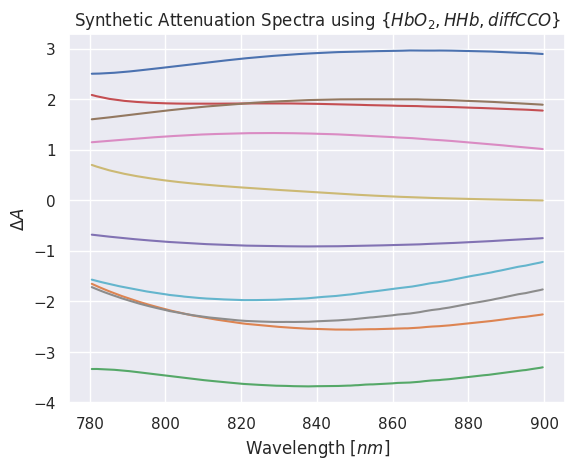

In [7]:
for i in range(0,10):
    plt.plot(x, spectra[i,:,:])

plt.xlabel("Wavelength [$nm$]")
plt.ylabel("$\Delta A$")
plt.title("Synthetic Attenuation Spectra using $\{ HbO_2, HHb, diffCCO \}$")
plt.savefig("synthetic_spectra")

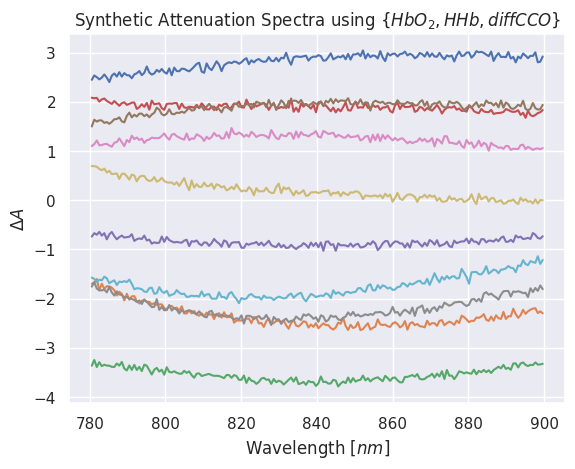

In [8]:
spectra_noisy = spectra + np.random.normal(0, 0.05, (spectra.shape[0], spectra.shape[1], 1))
for i in range(0,10):
    plt.plot(x, spectra_noisy[i,:,:])

plt.xlabel("Wavelength [$nm$]")
plt.ylabel("$\Delta A$")
plt.title("Synthetic Attenuation Spectra using $\{ HbO_2, HHb, diffCCO \}$")
plt.savefig("synthetic_spectra_noisy")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 19.33it/s]


1.0940074259932456e-30
['$diffCCO$'] 0.027348366217179045
['$HbO_2$', 'diffCC'] 0.005024924249662834
['$HbO_2$', '$HHb$', '$diffCCO$'] 1.0940074259932456e-30
['$HbO_2$', '$HHb$', '$diffCCO$', 'Fat'] 1.5022174399066187e-30
['$HbO_2$', '$HHb$', '$diffCCO$', 'Water', 'diffCB'] 2.385867753379782e-30
['$HbO_2$', '$HHb$', '$diffCCO$', 'Water', 'Fat', 'diffCB'] 3.1827413778557354e-30
['$HbO_2$', '$HHb$', '$diffCCO$', 'Water', 'Fat', 'diffCC', 'diffCB'] 1.813643828649131e-29


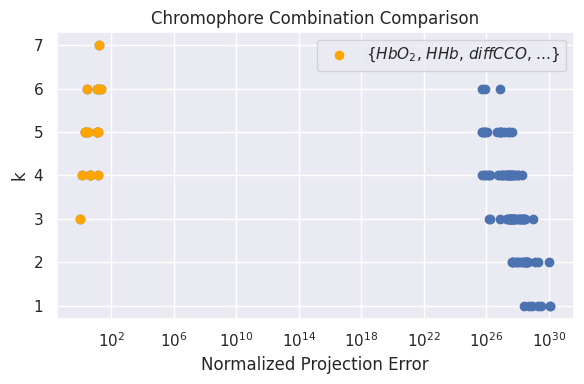

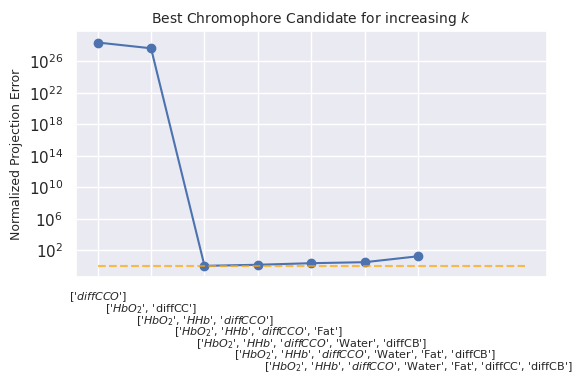

In [80]:
run_chromophore_selection(spectra)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 31.28it/s]


0.002408194690522899
['$diffCCO$'] 0.029901103396005244
['$HbO_2$', 'diffCC'] 0.007521549607015897
['$HbO_2$', '$HHb$', '$diffCCO$'] 0.002463195272587619
['$HbO_2$', '$HHb$', '$diffCCO$', 'Water'] 0.0024490254168790743
['$HbO_2$', '$HHb$', '$diffCCO$', 'diffCC', 'diffCB'] 0.0024347784303378837
['$HbO_2$', '$HHb$', '$diffCCO$', 'Water', 'diffCC', 'diffCB'] 0.0024214188620344202
['$HbO_2$', '$HHb$', '$diffCCO$', 'Water', 'Fat', 'diffCC', 'diffCB'] 0.002408194690522899


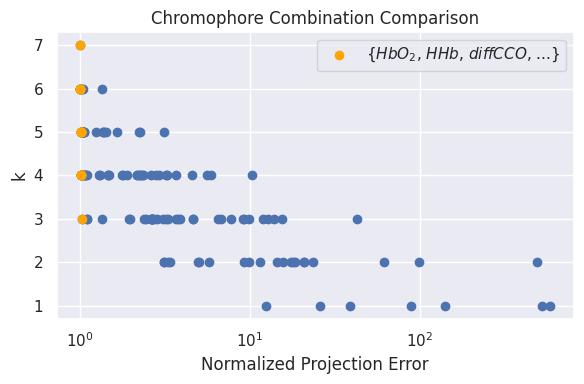

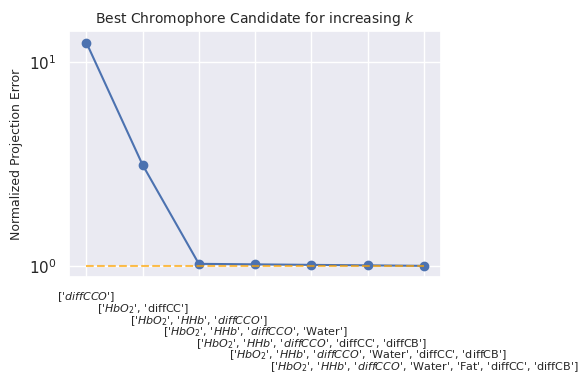

In [83]:
run_chromophore_selection(spectra_noisy, save_name="noise")

## Piglet Case

In [66]:
wavelengths, M, comp_spectr, y_hbo2_f, y_hb_f, y_coxa, y_creda, y_water, y_fat, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red = get_spectra_all_chromophores(left_cut, right_cut)

['lwp475', 'lwp478', 'lwp479-HI+saline', 'lwp494', 'lwp499', 'LWP480', 'LWP481', 'LWP484', 'LWP485', 'LWP489', 'LWP488', 'LWP490', 'LWP491', 'LWP492', 'LWP495', 'LWP498', 'LWP500', 'LWP501', 'LWP502']


In [67]:
wavelengths.shape

(183,)

In [68]:
comp_spectr.shape

(19000, 183)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.57it/s]


1.1864081945297173e-10
['$HbO_2$'] 5.489795902567758e-10
['$HbO_2$', '$HHb$'] 1.9286789918235376e-10
['$HbO_2$', '$HHb$', '$diffCCO$'] 1.2450477247035588e-10
['$HbO_2$', '$HHb$', 'Water', 'diffCC'] 1.209676393533557e-10
['$HbO_2$', '$HHb$', 'Water', 'diffCC', 'diffCB'] 1.19770902740915e-10
['$HbO_2$', '$HHb$', 'Water', 'Fat', 'diffCC', 'diffCB'] 1.1905261402522843e-10
['$HbO_2$', '$HHb$', '$diffCCO$', 'Water', 'Fat', 'diffCC', 'diffCB'] 1.1864081945297173e-10


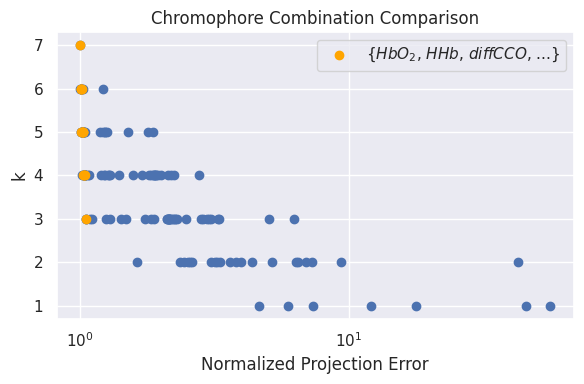

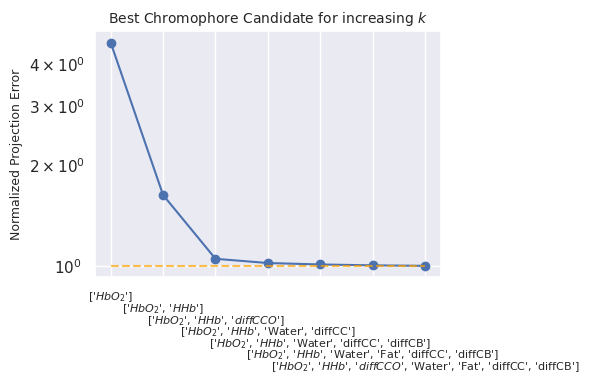

In [92]:
run_chromophore_selection(comp_spectr[:,:,np.newaxis], save_name="piglets")

In [69]:
chromophores = [np.asarray(y_hbo2_f),
np.asarray(y_hb_f),
np.asarray(y_coxa - y_creda),
np.asarray(y_cytoc_oxy - y_cytoc_red),
np.asarray(y_cytob_oxy - y_cytob_red),                              
np.asarray(y_water),
np.asarray(y_fat)]
chromophore_names = ["HbO2", "HHb", "diffCCO", "diffCC", "diffCB", "Water", "Fat"]

num_of_final_wavelengths = comp_spectr.shape[1]

In [70]:
projection_result = []

#for k in range(2, len(chromophores)):
for k in range(2, 7):
    results = []
    results_names = []
    for combo_indices in combinations(range(len(chromophores)), k):
        combo = [chromophores[i] for i in combo_indices] 
        results.append(np.transpose(np.vstack(combo)))
        results_names.append(([chromophore_names[i] for i in combo_indices]))

    
    for i, M in tqdm(enumerate(results)):
        wavelengths_downsampled = wavelengths[:]
        M_downsampled = M[:,:]
        k = M.shape[1]
        comp_spectr_downsampled = comp_spectr[:,:]
        #plt.figure()
        print(results_names[i])
        M_red, remaining_indices = reduce_wavelengths(M_downsampled, comp_spectr_downsampled.T[:, :], num_of_final_wavelengths, projection_metric)
        #plt.plot(wavelengths_downsampled, M_downsampled)
        #plt.vlines(wavelengths_downsampled[remaining_indices], np.min(M_downsampled), np.max(M_downsampled), color="black", linestyle="dashed", alpha=0.5)
        #print(wavelengths_downsampled[remaining_indices])
        projection_error = projection_metric(M_downsampled[remaining_indices,:],comp_spectr_downsampled.T[remaining_indices, :])
        #print(projection_error)
        #plt.show()
        #projection_result.append((k, results_names[i], M_red, projection_error, 1 / np.prod(np.linalg.svd(M_red, compute_uv=False)), wavelengths_downsampled[remaining_indices], M_downsampled, wavelengths_downsampled))
        projection_result.append((k, results_names[i], M_red, projection_error, k, wavelengths_downsampled[remaining_indices], M_downsampled, wavelengths_downsampled))

0it [00:00, ?it/s]

['HbO2', 'HHb']
Desired number of wavelengths is >= current number of wavelengths.


2it [00:00,  5.42it/s]

['HbO2', 'diffCCO']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'diffCC']
Desired number of wavelengths is >= current number of wavelengths.


4it [00:00,  4.21it/s]

['HbO2', 'diffCB']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'Water']
Desired number of wavelengths is >= current number of wavelengths.


6it [00:01,  6.33it/s]

['HbO2', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCCO']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCC']
Desired number of wavelengths is >= current number of wavelengths.


10it [00:01,  9.50it/s]

['HHb', 'diffCB']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


14it [00:01, 13.09it/s]

['diffCCO', 'diffCC']
Desired number of wavelengths is >= current number of wavelengths.
['diffCCO', 'diffCB']
Desired number of wavelengths is >= current number of wavelengths.
['diffCCO', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['diffCCO', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


16it [00:01, 12.51it/s]

['diffCC', 'diffCB']
Desired number of wavelengths is >= current number of wavelengths.
['diffCC', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['diffCC', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


21it [00:02,  9.82it/s]


['diffCB', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['diffCB', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


0it [00:00, ?it/s]

['HbO2', 'HHb', 'diffCCO']
Desired number of wavelengths is >= current number of wavelengths.


2it [00:00, 18.10it/s]

['HbO2', 'HHb', 'diffCC']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'HHb', 'diffCB']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'HHb', 'Water']
Desired number of wavelengths is >= current number of wavelengths.


4it [00:00, 17.89it/s]

['HbO2', 'HHb', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


6it [00:00, 17.69it/s]

['HbO2', 'diffCCO', 'diffCC']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'diffCCO', 'diffCB']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'diffCCO', 'Water']
Desired number of wavelengths is >= current number of wavelengths.


8it [00:00, 16.46it/s]

['HbO2', 'diffCCO', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


10it [00:00, 14.64it/s]

['HbO2', 'diffCC', 'diffCB']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'diffCC', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'diffCC', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


12it [00:00, 13.81it/s]

['HbO2', 'diffCB', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'diffCB', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


14it [00:00, 13.50it/s]

['HbO2', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


16it [00:01, 13.61it/s]

['HHb', 'diffCCO', 'diffCC']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCCO', 'diffCB']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCCO', 'Water']
Desired number of wavelengths is >= current number of wavelengths.


18it [00:01, 13.44it/s]

['HHb', 'diffCCO', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCC', 'diffCB']
Desired number of wavelengths is >= current number of wavelengths.


20it [00:01, 13.24it/s]

['HHb', 'diffCC', 'Water']
Desired number of wavelengths is >= current number of wavelengths.


22it [00:01, 12.22it/s]

['HHb', 'diffCC', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCB', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCB', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


24it [00:01, 12.42it/s]

['HHb', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['diffCCO', 'diffCC', 'diffCB']
Desired number of wavelengths is >= current number of wavelengths.


26it [00:01, 12.59it/s]

['diffCCO', 'diffCC', 'Water']
Desired number of wavelengths is >= current number of wavelengths.


28it [00:02, 13.09it/s]

['diffCCO', 'diffCC', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['diffCCO', 'diffCB', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['diffCCO', 'diffCB', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


30it [00:02, 13.38it/s]

['diffCCO', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['diffCC', 'diffCB', 'Water']
Desired number of wavelengths is >= current number of wavelengths.


32it [00:02, 12.94it/s]

['diffCC', 'diffCB', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


34it [00:02, 13.84it/s]

['diffCC', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['diffCB', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


35it [00:02, 13.07it/s]
1it [00:00,  9.78it/s]

['HbO2', 'HHb', 'diffCCO', 'diffCC']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'HHb', 'diffCCO', 'diffCB']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'HHb', 'diffCCO', 'Water']
Desired number of wavelengths is >= current number of wavelengths.


3it [00:00, 10.89it/s]

['HbO2', 'HHb', 'diffCCO', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'HHb', 'diffCC', 'diffCB']
Desired number of wavelengths is >= current number of wavelengths.


7it [00:00, 10.87it/s]

['HbO2', 'HHb', 'diffCC', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'HHb', 'diffCC', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'HHb', 'diffCB', 'Water']
Desired number of wavelengths is >= current number of wavelengths.


11it [00:00, 13.27it/s]

['HbO2', 'HHb', 'diffCB', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'HHb', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'diffCCO', 'diffCC', 'diffCB']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'diffCCO', 'diffCC', 'Water']
Desired number of wavelengths is >= current number of wavelengths.


17it [00:01, 18.68it/s]

['HbO2', 'diffCCO', 'diffCC', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'diffCCO', 'diffCB', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'diffCCO', 'diffCB', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'diffCCO', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'diffCC', 'diffCB', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'diffCC', 'diffCB', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


20it [00:01, 20.09it/s]

['HbO2', 'diffCC', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'diffCB', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCCO', 'diffCC', 'diffCB']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCCO', 'diffCC', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCCO', 'diffCC', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


26it [00:01, 19.87it/s]

['HHb', 'diffCCO', 'diffCB', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCCO', 'diffCB', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCCO', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCC', 'diffCB', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCC', 'diffCB', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


32it [00:01, 21.70it/s]

['HHb', 'diffCC', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCB', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['diffCCO', 'diffCC', 'diffCB', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['diffCCO', 'diffCC', 'diffCB', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['diffCCO', 'diffCC', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


35it [00:01, 17.59it/s]


['diffCCO', 'diffCB', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['diffCC', 'diffCB', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


0it [00:00, ?it/s]

['HbO2', 'HHb', 'diffCCO', 'diffCC', 'diffCB']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'HHb', 'diffCCO', 'diffCC', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'HHb', 'diffCCO', 'diffCC', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


3it [00:00, 23.80it/s]

['HbO2', 'HHb', 'diffCCO', 'diffCB', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'HHb', 'diffCCO', 'diffCB', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


6it [00:00, 21.88it/s]

['HbO2', 'HHb', 'diffCCO', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'HHb', 'diffCC', 'diffCB', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'HHb', 'diffCC', 'diffCB', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


9it [00:00, 18.59it/s]

['HbO2', 'HHb', 'diffCC', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'HHb', 'diffCB', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'diffCCO', 'diffCC', 'diffCB', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'diffCCO', 'diffCC', 'diffCB', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


12it [00:00, 20.12it/s]

['HbO2', 'diffCCO', 'diffCC', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


15it [00:00, 20.17it/s]

['HbO2', 'diffCCO', 'diffCB', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'diffCC', 'diffCB', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCCO', 'diffCC', 'diffCB', 'Water']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCCO', 'diffCC', 'diffCB', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


18it [00:00, 19.95it/s]

['HHb', 'diffCCO', 'diffCC', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCCO', 'diffCB', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HHb', 'diffCC', 'diffCB', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['diffCCO', 'diffCC', 'diffCB', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


21it [00:01, 20.02it/s]
0it [00:00, ?it/s]

['HbO2', 'HHb', 'diffCCO', 'diffCC', 'diffCB', 'Water']
Desired number of wavelengths is >= current number of wavelengths.


2it [00:00, 17.74it/s]

['HbO2', 'HHb', 'diffCCO', 'diffCC', 'diffCB', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'HHb', 'diffCCO', 'diffCC', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'HHb', 'diffCCO', 'diffCB', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.
['HbO2', 'HHb', 'diffCC', 'diffCB', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


5it [00:00, 20.27it/s]

['HbO2', 'diffCCO', 'diffCC', 'diffCB', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


7it [00:00, 16.98it/s]

['HHb', 'diffCCO', 'diffCC', 'diffCB', 'Water', 'Fat']
Desired number of wavelengths is >= current number of wavelengths.


In [71]:
#projection_result_sorted = sorted(projection_result, key=lambda x: (x[0], x[3], x[1]))
projection_result_sorted = (sorted(projection_result, key=lambda x: (x[4])))
errors_projection = []

fitting_error = []
svdprod_inv = []

def normalize(data):
    return data / np.min(data)
    
name = []
for result in projection_result_sorted:
    #errors_projection.append(result[2])
    errors_projection.append((result[0], result[3], result[1]))
    fitting_error.append(result[3])
    svdprod_inv.append(result[4])
    name.append(result[1])

fitting_error = normalize(np.array(fitting_error))
svdprod_inv = np.array(svdprod_inv)


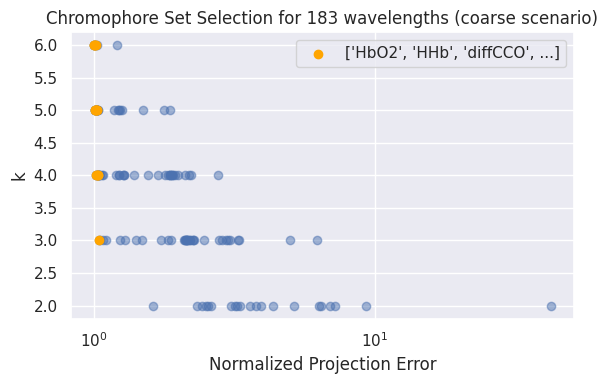

In [72]:
eucl_distance_index = np.argsort(np.sqrt(np.array(fitting_error)**2 + np.array(svdprod_inv)**2))

fig,axs = plt.subplots(1,1, figsize=(6,4))
axs.scatter(fitting_error, svdprod_inv, alpha=0.5)

for index in eucl_distance_index:
    if ['HbO2', 'HHb', 'diffCCO'] == name[eucl_distance_index[index]]:
       axs.scatter(fitting_error[eucl_distance_index[index]], svdprod_inv[eucl_distance_index[index]], label="['HbO2', 'HHb', 'diffCCO', ...]",color="orange")
    elif set(['HbO2', 'HHb', 'diffCCO']).issubset(name[eucl_distance_index[index]]):
       axs.scatter(fitting_error[eucl_distance_index[index]], svdprod_inv[eucl_distance_index[index]], color="orange") 
# axs[0].scatter(fitting_error[eucl_distance_index[0]], svdprod_inv[eucl_distance_index[1]], label=name[eucl_distance_index[0]])
# axs[0].scatter(fitting_error[eucl_distance_index[1]], svdprod_inv[eucl_distance_index[1]], label=name[eucl_distance_index[1]])
# axs[0].scatter(fitting_error[eucl_distance_index[2]], svdprod_inv[eucl_distance_index[2]], label=name[eucl_distance_index[2]])
# axs[0].scatter(fitting_error[eucl_distance_index[3]], svdprod_inv[eucl_distance_index[3]], label=name[eucl_distance_index[3]])
# axs[0].scatter(fitting_error[eucl_distance_index[4]], svdprod_inv[eucl_distance_index[4]], label=name[eucl_distance_index[4]])
# axs[0].scatter(fitting_error[eucl_distance_index[5]], svdprod_inv[eucl_distance_index[5]], label=name[eucl_distance_index[5]])
# axs[0].scatter(fitting_error[eucl_distance_index[6]], svdprod_inv[eucl_distance_index[6]], label=name[eucl_distance_index[6]])

#axs[0].quiver(0, 0, fitting_error[eucl_distance_index[0]], svdprod_inv[eucl_distance_index[0]], angles='xy', scale_units='xy', scale=1, color='green')

#axs[0].set_xlabel("Spectral Fitting Error (scaled by min)")
axs.set_xlabel("Normalized Projection Error")
#axs[0].set_ylabel("1 / (Product SVD Values)")
axs.set_ylabel("k")
axs.set_xscale("log")
#axs[0].set_yscale("log")
axs.set_title("Chromophore Set Selection for " +  str(len(projection_result_sorted[eucl_distance_index[0]][-3])) + " wavelengths (coarse scenario)")
axs.legend(loc="best")
plt.tight_layout()
plt.savefig("chr_set_selection_coarse_one_piglet")

1.1905261402522848e-10
['HbO2', 'HHb'] 1.9286789918235376e-10
['HbO2', 'HHb', 'diffCCO'] 1.2450477247035588e-10
['HbO2', 'HHb', 'diffCC', 'Water'] 1.2096763935335567e-10
['HbO2', 'HHb', 'diffCC', 'diffCB', 'Water'] 1.1977090274091494e-10
['HbO2', 'HHb', 'diffCC', 'diffCB', 'Water', 'Fat'] 1.1905261402522848e-10


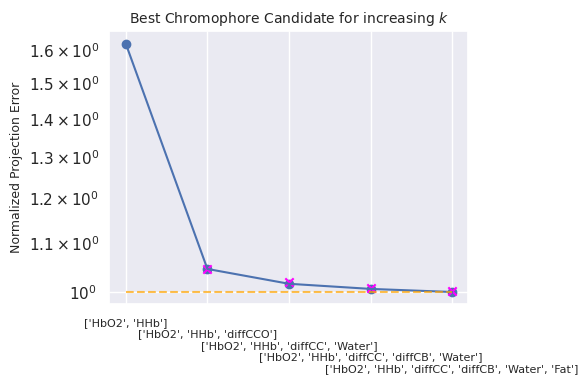

In [86]:
name = []
fitting_error_arr = []
for result in projection_result_sorted:
    #errors_projection.append(result[2])
    fitting_error_arr.append(result[3])

min_fitting_error = np.min(np.array(fitting_error_arr))
print(min_fitting_error)

projection_result_sorted = (sorted(projection_result, key=lambda x: (x[3])))
projection_result_sorted
import pandas as pd
df = pd.DataFrame(projection_result, columns=['length', 'chromophores', 'x', 'mean_error', 'length_dup', 'y', 'z', 'a'])
top_3_results = df.groupby('length').apply(lambda group: group.nsmallest(1, 'mean_error')).reset_index(drop=True)

x_axis = []
x_axis_label = []
y_axis = []
for i in range(len(top_3_results)):
    print([tuple(row) for row in top_3_results.to_numpy()][i][1], [tuple(row) for row in top_3_results.to_numpy()][i][3])
    x_axis.append(i)
    x_axis_label.append("\n"*i+str([tuple(row) for row in top_3_results.to_numpy()][i][1]))
    y_axis.append([tuple(row) for row in top_3_results.to_numpy()][i][3] / min_fitting_error)

plt.figure(figsize=(6,4))
plt.plot(x_axis,y_axis)
plt.scatter(x_axis,y_axis)
plt.xticks(x_axis, x_axis_label, fontsize=8)
plt.hlines(1,0,4, linestyles='--',alpha=0.7, color="orange")
plt.yscale("log")

filtered_df = df[df['chromophores'].apply(lambda x: x[:3] == ['HbO2', 'HHb', 'diffCCO'])]
#sorted_df = filtered_df.sort_values(by='mean_error')
min_score_per_k = filtered_df.loc[filtered_df.groupby('length')['mean_error'].idxmin()]
other_diffcco_k = min_score_per_k['length'].to_numpy()
other_diffcco_error = min_score_per_k['mean_error'].to_numpy() / min_fitting_error

plt.scatter(other_diffcco_k - 2, other_diffcco_error, marker='x', color='magenta')

plt.ylabel("Normalized Projection Error",fontsize=9)
plt.title("Best Chromophore Candidate for increasing $k$", fontsize=10)
#for i in range(len(projection_result_sorted)):
#    print(projection_result_sorted[i][1], projection_result_sorted[i][3])
plt.tight_layout()
plt.savefig("chromophore_candidate_increasing_k")

## 3. Simultaneous Chromophore and Wavelength Selection

In [9]:
left_cut = 730
right_cut = 940
wavelengths, M, comp_spectr, y_hbo2_f, y_hb_f, y_coxa, y_creda, y_water, y_fat, y_cytoc_oxy, y_cytoc_red, y_cytob_oxy, y_cytob_red = get_spectra_all_chromophores(left_cut, right_cut)

['lwp475', 'lwp478', 'lwp479-HI+saline', 'lwp494', 'lwp499', 'LWP480', 'LWP481', 'LWP484', 'LWP485', 'LWP489', 'LWP488', 'LWP490', 'LWP491', 'LWP492', 'LWP495', 'LWP498', 'LWP500', 'LWP501', 'LWP502']


In [10]:
len(wavelengths)

321

In [ ]:
start = time.time()
#selection_result = run_chromophore_wavelength_selection(comp_spectr[:,:,np.newaxis], 30, coarseness=1, data_coarseness=10)
#selection_result = run_chromophore_wavelength_selection(comp_spectr[:,:,np.newaxis], 160, coarseness=1, data_coarseness=10)
selection_result = run_chromophore_wavelength_selection(comp_spectr[:,:,np.newaxis], 153, coarseness=1, data_coarseness=10)

end = time.time()

  0%|                                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

In [305]:
(end-start)/(60*60)

8.362887951466773

In [306]:
type(selection_result)

list

In [307]:
projection_result_sorted = (sorted(selection_result, key=lambda x: (x[2])))
import pandas as pd
df = pd.DataFrame(projection_result_sorted, columns=['length', 'chromophores', 'mean_error', 'wavelengths_selected', 'all_wls'])
top_3_results = df.groupby('length').apply(lambda group: group.nsmallest(1, 'mean_error')).reset_index(drop=True)

In [308]:
errors_projection = []
fitting_error = []
svdprod_inv = []

def normalize(data):
    return data / np.min(data)
    
name = []
for result in projection_result_sorted:
    #errors_projection.append(result[2])
    errors_projection.append((result[0], result[1], result[2]))
    fitting_error.append(result[2])
    svdprod_inv.append(result[0])
    name.append(result[1])

fitting_error = normalize(np.array(fitting_error))
svdprod_inv = np.array(svdprod_inv)

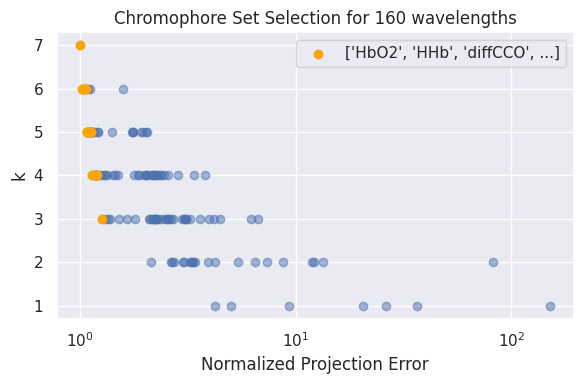

In [309]:
eucl_distance_index = np.argsort(np.sqrt(np.array(fitting_error)**2 + np.array(svdprod_inv)**2))

fig,axs = plt.subplots(1,1, figsize=(6,4))
axs.scatter(fitting_error, svdprod_inv, alpha=0.5)

for index in eucl_distance_index:
    if ['$HbO_2$', '$HHb$', '$diffCCO$'] == name[eucl_distance_index[index]]:
       axs.scatter(fitting_error[eucl_distance_index[index]], svdprod_inv[eucl_distance_index[index]], label="['HbO2', 'HHb', 'diffCCO', ...]",color="orange")
    elif set(['$HbO_2$', '$HHb$', '$diffCCO$']).issubset(name[eucl_distance_index[index]]):
       axs.scatter(fitting_error[eucl_distance_index[index]], svdprod_inv[eucl_distance_index[index]], color="orange") 
# axs[0].scatter(fitting_error[eucl_distance_index[0]], svdprod_inv[eucl_distance_index[1]], label=name[eucl_distance_index[0]])
# axs[0].scatter(fitting_error[eucl_distance_index[1]], svdprod_inv[eucl_distance_index[1]], label=name[eucl_distance_index[1]])
# axs[0].scatter(fitting_error[eucl_distance_index[2]], svdprod_inv[eucl_distance_index[2]], label=name[eucl_distance_index[2]])
# axs[0].scatter(fitting_error[eucl_distance_index[3]], svdprod_inv[eucl_distance_index[3]], label=name[eucl_distance_index[3]])
# axs[0].scatter(fitting_error[eucl_distance_index[4]], svdprod_inv[eucl_distance_index[4]], label=name[eucl_distance_index[4]])
# axs[0].scatter(fitting_error[eucl_distance_index[5]], svdprod_inv[eucl_distance_index[5]], label=name[eucl_distance_index[5]])
# axs[0].scatter(fitting_error[eucl_distance_index[6]], svdprod_inv[eucl_distance_index[6]], label=name[eucl_distance_index[6]])

#axs[0].quiver(0, 0, fitting_error[eucl_distance_index[0]], svdprod_inv[eucl_distance_index[0]], angles='xy', scale_units='xy', scale=1, color='green')

#axs[0].set_xlabel("Spectral Fitting Error (scaled by min)")
axs.set_xlabel("Normalized Projection Error")
#axs[0].set_ylabel("1 / (Product SVD Values)")
axs.set_ylabel("k")
axs.set_xscale("log")
#axs[0].set_yscale("log")
axs.set_title("Chromophore Set Selection for " +  str(len(projection_result_sorted[eucl_distance_index[0]][-2])) + " wavelengths")
axs.legend(loc="best")
plt.tight_layout()

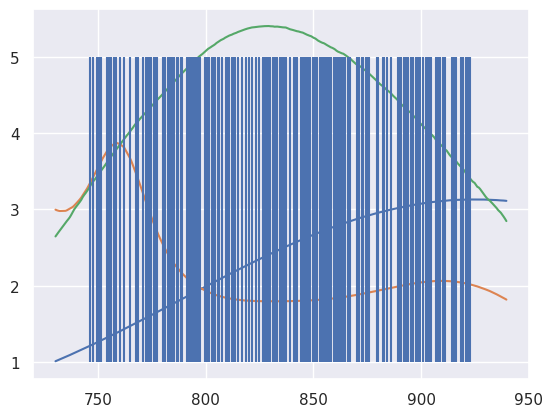

In [310]:
plt.plot(wavelengths, y_hbo2_f)
plt.plot(wavelengths, y_hb_f)
plt.plot(wavelengths, y_coxa - y_creda)
plt.vlines(top_3_results.iloc[2]["wavelengths_selected"], 1, 5)

In [311]:
len(projection_result_sorted[0][-1])

321

In [312]:
top_3_results.iloc[2]["chromophores"]

['$HbO_2$', '$HHb$', '$diffCCO$']

In [313]:
top_3_results.iloc[2]["chromophores"]
top_3_results.iloc[2]["wavelengths_selected"]

array([746.073657  , 747.40252554, 749.39532344, 750.05945461,
       750.72351831, 751.3875145 , 754.04282336, 754.7064814 ,
       755.37007169, 756.03359418, 757.36043563, 758.0237545 ,
       760.01330323, 762.00223926, 764.65319902, 767.303065  ,
       768.62758703, 770.61385543, 771.93769081, 773.26125096,
       773.92292772, 774.58453556, 775.90754428, 776.56894509,
       777.23027681, 779.87491198, 780.53589764, 781.19681396,
       782.51843845, 783.17914653, 783.83978512, 784.50035417,
       785.16085364, 786.4816437 , 787.1419342 , 788.46230594,
       789.1223871 , 791.10221126, 791.76201274, 792.42174419,
       793.08140558, 793.74099686, 794.400518  , 795.05996896,
       795.71934969, 796.37866016, 797.03790031, 799.67415706,
       800.33304508, 801.65060942, 802.96789124, 803.6264261 ,
       804.28489021, 805.601606  , 806.25985761, 807.57614804,
       809.55005111, 810.20787662, 810.86563097, 812.18092603,
       812.83846666, 813.49593597, 814.81066048, 816.78

In [284]:
top_3_results.iloc[3]["chromophores"]

['$HbO_2$', '$HHb$', '$diffCCO$', 'Water']

In [283]:
top_3_results.iloc[2]["wavelengths_selected"]

array([788.46230594, 793.74099686, 794.400518  , 796.37866016,
       799.67415706, 800.33304508, 801.65060942, 803.6264261 ,
       805.601606  , 828.59795246, 829.25369792, 831.87595601,
       835.15214714, 844.31579717, 849.54572828, 850.85247595,
       853.46508691, 856.07651652, 859.33913831, 861.29582131,
       862.59990511, 865.85881186, 866.51036956, 867.16185261,
       872.37102493, 874.32322799, 882.12526741, 889.91641776,
       893.15949996, 900.93510417])

In [304]:
top_3_results.iloc[2]["all_wls"]

array([730.10635316, 730.77242327, 731.43842708, 732.10436457,
       732.77023567, 733.43604037, 734.10177861, 734.76745036,
       735.43305557, 736.0985942 , 736.76406622, 737.42947158,
       738.09481024, 738.76008217, 739.42528731, 740.09042564,
       740.7554971 , 741.42050167, 742.08543929, 742.75030993,
       743.41511355, 744.07985011, 744.74451956, 745.40912187,
       746.073657  , 746.7381249 , 747.40252554, 748.06685887,
       748.73112485, 749.39532344, 750.05945461, 750.72351831,
       751.3875145 , 752.05144314, 752.71530419, 753.37909761,
       754.04282336, 754.7064814 , 755.37007169, 756.03359418,
       756.69704884, 757.36043563, 758.0237545 , 758.68700542,
       759.35018834, 760.01330323, 760.67635004, 761.33932873,
       762.00223926, 762.6650816 , 763.3278557 , 763.99056152,
       764.65319902, 765.31576816, 765.97826889, 766.64070119,
       767.303065  , 767.9653603 , 768.62758703, 769.28974515,
       769.95183463, 770.61385543, 771.2758075 , 771.93